In [1]:
import os
import mne
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import ghostipy
from ghostipy.spectral.wavelets import MorseWavelet

import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
#from torch.utils.tensorboard import SummaryWriter

from mne.time_frequency import morlet
from mne.time_frequency.tfr import cwt
from mne.time_frequency import tfr_morlet
from mne import create_info, EpochsArray
from mne.channels import make_dig_montage
from mne.preprocessing import ICA


In [2]:
class resnet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

        self.convolutional_layers = nn.Sequential(resnet.conv1,
                                   resnet.bn1,
                                   resnet.relu,
                                   resnet.maxpool,
                                   resnet.layer1,
                                   resnet.layer2,
                                   resnet.layer3,
                                   resnet.layer4)

        # # Add back the batch norm layer that we removed
        self.avgpool = resnet.avgpool # Global Average pooling layer

        # # # Custom fully connect layer
        self.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=num_classes) 

        # gradient placeholder
        self.gradient = None

    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.convolutional_layers(x)
    
    def forward(self, images):        
        # Convolutional layers of resnet18
        x = self.convolutional_layers(images) 
               
        # # The layers after the Conv you used the hook on
        h = x.register_hook(self.activations_hook)
        
        # Global average pooling layer from resnet18
        x = self.avgpool(x)
        
        x = x.reshape(x.size(0), -1)
        logits = self.fc(x)
        
        output = F.sigmoid(logits)
        return output

In [3]:
import os
from PIL import Image
from torchvision import transforms

# Define the transformation
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [4]:
#load model 
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet(num_classes=1).to(device)
model_num = 20
checkpoint_path = ""
checkpoint = torch.load(f'resnet-finetune-adam-epoch_{model_num}.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])


Using cache found in /home/dheeraj/.cache/torch/hub/pytorch_vision_v0.10.0
/home/dheeraj/Desktop/projects/scizo_frontend/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dheeraj/Desktop/projects/scizo_frontend/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [16]:
image = Image.open("image_buffer/C4.png")
if image.mode == 'RGBA':
    image = image.convert('RGB')
transformed_image = preprocess(image)
transformed_image_unsquee = transformed_image.unsqueeze(0)
model.eval()
ans =  model(transformed_image_unsquee)
print(ans)


tensor([[0.9994]], grad_fn=<SigmoidBackward0>)


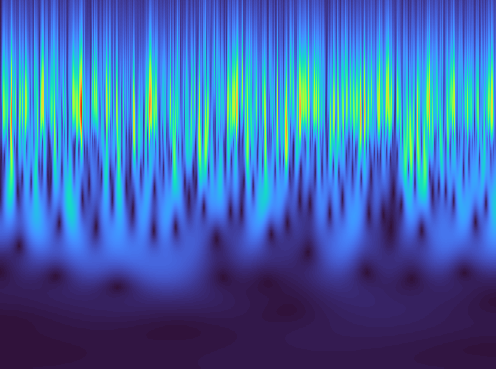

In [14]:
image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


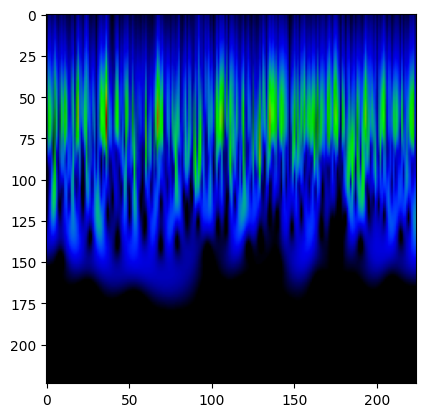

In [13]:
plt.imshow(transformed_image.permute(1, 2, 0))

In [15]:
model.eval()

resnet(
  (convolutional_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
import os
from PIL import Image
from torchvision import transforms

# Define the transformation
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Specify the input folder
input_folder = "image_buffer"

# List all files in the input folder
image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

# Apply the transformation to each image and overwrite the original images
for image_file in image_files:
    # Load the image
    input_path = os.path.join(input_folder, image_file)
    image = Image.open(input_path)

    # Apply the transformation
    transformed_image = preprocess(image)

    # Convert the transformed image to a PIL Image
    pil_transformed_image = transforms.ToPILImage()(transformed_image)

    # Save the transformed image, overwriting the original image
    pil_transformed_image.save(input_path)

print("Transformation completed.")
